In [1]:
import sys
import os

# Add parent directory to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
from modules.spin_system_experimental import SpinSystem

import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt


2025-09-14 18:29:17.413227: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-14 18:29:17.443482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-14 18:29:18.159841: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
def generate_decaying_coupling_tensor(D, L, J0=10, alpha=1):
    coords = np.array(np.meshgrid(*[np.arange(L)]*D, indexing='ij')).reshape(D, -1).T

    # Pairwise Euclidean distances
    diff = coords[:, None, :] - coords[None, :, :]
    distances = np.linalg.norm(diff, axis=2)
    J_flat = J0 * np.exp(-alpha * distances)
    np.fill_diagonal(J_flat, 0)

    # Vectorized reshape
    tensor_shape = (L,)*D*2
    J_tensor = J_flat.reshape(tensor_shape)

    return J_tensor

def generate_periodic_nn_coupling_tensor(D, L):
    """
    Vectorized nearest-neighbor coupling tensor with periodic boundaries.
    J[i1,...,iD,j1,...,jD] = 1 if periodic Manhattan distance = 1, else 0
    """
    # Generate all coordinates: shape (N, D)
    coords = np.array(np.meshgrid(*[np.arange(L)]*D, indexing='ij')).reshape(D, -1).T
    N = coords.shape[0]

    # Compute pairwise differences with broadcasting
    diff = np.abs(coords[:, None, :] - coords[None, :, :])
    
    # Apply periodic boundary
    diff = np.minimum(diff, L - diff)

    # Manhattan distance
    manhattan_dist = diff.sum(axis=2)

    # Nearest neighbors mask
    nn_mask = (manhattan_dist == 1)

    # Create empty tensor and set neighbors
    J_tensor = np.zeros((L,)*D*2, dtype=np.float32)
    
    # Get indices where nn_mask is True
    idx_i, idx_j = np.nonzero(nn_mask)
    
    # Set values in the tensor
    for i, j in zip(idx_i, idx_j):
        J_tensor[tuple(coords[i]) + tuple(coords[j])] = 1.0

    return J_tensor

In [ ]:
lattice_dim = 2
lattice_length = 100

interaction_matrix = generate_periodic_nn_coupling_tensor(lattice_dim, lattice_length)
spin_system = SpinSystem(
    lattice_dim=lattice_dim,
    lattice_length=lattice_length,
    interaction_matrix=interaction_matrix,
    ising=True,
    initial_magnetization=0.5
)

sweep_length = 30000
beta = 3

results = spin_system.metropolis_sweep(
    beta=beta,
    num_disturb=4,
    sweep_length=sweep_length,
    track_spins=True,
    track_energy=True,
    track_magnetization=True
)

I0000 00:00:1757885361.617113   99392 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


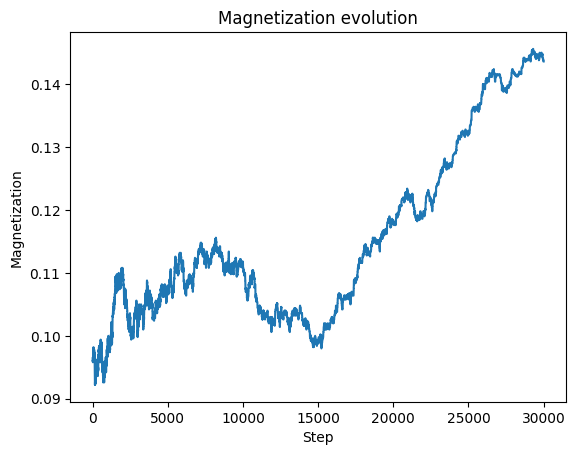

In [5]:
# --------------------------
# Plot energy evolution
# --------------------------
# energy_evolution = results['energy_evolution'].numpy()
# plt.figure()
# plt.plot(energy_evolution)
# plt.xlabel("Step")
# plt.ylabel("Energy")
# plt.title("Energy evolution")
# plt.show()

# --------------------------
# Plot magnetization evolution
# --------------------------
magnetization_evolution = results['magnetization_evolution'].numpy()
plt.figure()
plt.plot(magnetization_evolution)
plt.xlabel("Step")
plt.ylabel("Magnetization")
plt.title("Magnetization evolution")
plt.show()

# --------------------------
# Plot spins evolution
# --------------------------
# spin_evolution = results['spin_evolution'].numpy()

# Reduce steps if too many for animation (10001 frames is very heavy!)
# steps_to_show = 1000  # pick every 50th step for example
# frames_idx = np.linspace(0, spin_evolution.shape[0]-1, steps_to_show, dtype=int)

# # Create base figure
# fig = go.Figure(
#     data=[go.Heatmap(z=spin_evolution[0], colorscale="RdBu", zmin=-1, zmax=1)],
#     layout=go.Layout(
#         title="Spin Evolution Heatmap",
#         width=1000,
#         height=1000,
#         xaxis=dict(showgrid=False, zeroline=False),
#         yaxis=dict(showgrid=False, zeroline=False, scaleanchor="x"),
#         updatemenus=[dict(
#             type="buttons",
#             showactive=False,
#             buttons=[
#                 dict(label="Play", method="animate",
#                      args=[None, {"frame": {"duration": 50, "redraw": True},
#                                   "fromcurrent": True, "transition": {"duration": 0}}]),
#                 dict(label="Pause", method="animate",
#                      args=[[None], {"frame": {"duration": 0, "redraw": False},
#                                     "mode": "immediate",
#                                     "transition": {"duration": 0}}])
#             ]
#         )]
#     ),
#     frames=[
#         go.Frame(data=[go.Heatmap(z=spin_evolution[k], colorscale="RdBu", zmin=-1, zmax=1)],
#                  name=str(k))
#         for k in frames_idx
#     ]
# )

# fig.show()


In [6]:
interaction_matrix = 2*generate_decaying_coupling_tensor(lattice_dim, lattice_length)
spin_system = SpinSystem(
    lattice_dim=lattice_dim,
    lattice_length=lattice_length,
    interaction_matrix=interaction_matrix,
    ising=False,
    spherical_constraint=True,
    initial_magnetization=0.1
)

sweep_length = 10000
beta = 3

results = spin_system.metropolis_sweep(
    beta=beta,
    num_disturb=4,
    theta_max=np.pi,
    sweep_length=sweep_length,
    track_spins=False,
    track_energy=False,
    track_magnetization=True
)

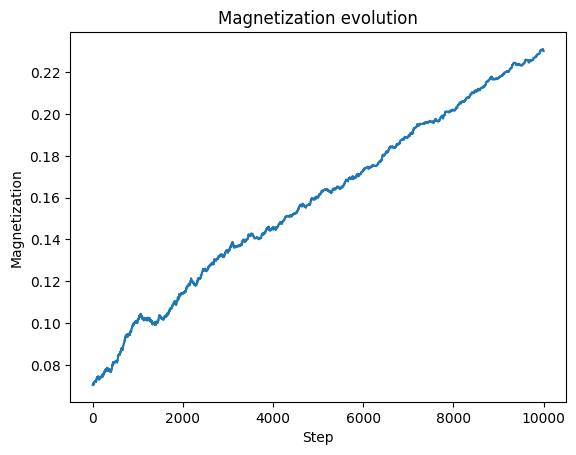

In [7]:
# --------------------------
# Plot energy evolution
# --------------------------
# energy_evolution = results['energy_evolution'].numpy()
# plt.figure()
# plt.plot(energy_evolution)
# plt.xlabel("Step")
# plt.ylabel("Energy")
# plt.title("Energy evolution")
# plt.show()

# --------------------------
# Plot magnetization evolution
# --------------------------
magnetization_evolution = results['magnetization_evolution'].numpy()
plt.figure()
plt.plot(magnetization_evolution)
plt.xlabel("Step")
plt.ylabel("Magnetization")
plt.title("Magnetization evolution")
plt.show()

# --------------------------
# Plot spins evolution
# --------------------------
# spin_evolution = results['spin_evolution'].numpy()

# steps_to_show = 10000 
# frames_idx = np.linspace(0, spin_evolution.shape[0]-1, steps_to_show, dtype=int)

# # Create base figure
# fig = go.Figure(
#     data=[go.Heatmap(z=spin_evolution[0], colorscale="RdBu", zmin=-1, zmax=1)],
#     layout=go.Layout(
#         title="Spin Evolution Heatmap",
#         width=1000,
#         height=1000,
#         xaxis=dict(showgrid=False, zeroline=False),
#         yaxis=dict(showgrid=False, zeroline=False, scaleanchor="x"),
#         updatemenus=[dict(
#             type="buttons",
#             showactive=False,
#             buttons=[
#                 dict(label="Play", method="animate",
#                      args=[None, {"frame": {"duration": 50, "redraw": True},
#                                   "fromcurrent": True, "transition": {"duration": 0}}]),
#                 dict(label="Pause", method="animate",
#                      args=[[None], {"frame": {"duration": 0, "redraw": False},
#                                     "mode": "immediate",
#                                     "transition": {"duration": 0}}])
#             ]
#         )]
#     ),
#     frames=[
#         go.Frame(data=[go.Heatmap(z=spin_evolution[k], colorscale="RdBu", zmin=-1, zmax=1)],
#                  name=str(k))
#         for k in frames_idx
#     ]
# )

# fig.show()
